# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas
import numpy
import sklearn

# Load Data

In [2]:
train = pandas.read_csv('data/train.csv')
train.shape

(9557, 143)

In [3]:
train.head(2)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.0,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.0,64.0,144.0,4489,4


In [4]:
# Show distinct target values, set index

# Explore Data

## Information About Data Set

- One row represents one person.
- Multiple people can be part of a single household. Only predictions for heads of household are scored.

### Initial thoughts

- How are the 4 classes split - is there even representation?
- Is it necessary to do some feature selection
- Will it be easier to single out one particular class, or is this a linear scale (i.e. can we easily single out and throw away non vulnerable households then focus in on distinguishing further - "`v18q`, owns a tablet" might be a quick way to filter all households that are not vunerable)
- Think about important household features, use `idhogar` value to group by household
  - Number of people in household, look at overcrowding and household size stats
- `parentesco1` indicates whether someone is head of the household

### Is there equal distribution of each of the 4 classes?

In [5]:
population_target_sizes = train['Target'].value_counts().to_frame()
population_target_sizes.columns = ['total']
# population_target_sizes['proportion'] = population_target_sizes['total']/population_target_sizes['total'].sum()
population_target_sizes
# provide better column headers

,total
4,5996
2,1597
3,1209
1,755


## Check Data Types

In [6]:
def get_column_dtypes():
    columns_by_dtype = train.columns.groupby(train.dtypes)
    return {k.name: v for k, v in columns_by_dtype.items()}

In [7]:
get_column_dtypes()

{'int64': Index(['hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'r4h1', 'r4h2',
        'r4h3', 'r4m1',
        ...
        'area1', 'area2', 'age', 'SQBescolari', 'SQBage', 'SQBhogar_total',
        'SQBedjefe', 'SQBhogar_nin', 'agesq', 'Target'],
       dtype='object', length=130),
 'float64': Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'overcrowding',
        'SQBovercrowding', 'SQBdependency', 'SQBmeaned'],
       dtype='object'),
 'object': Index(['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa'], dtype='object')}

### Interpreting Object DTypes

In [8]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


#### Id

In [9]:
train = train.set_index('Id')
train.head(3)

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
Id,,,,,,,,,,,,,,,,,,,,,
ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,...,100,1849,1,100,0,1.00,0.0,100.0,1849,4
ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,...,144,4489,1,144,0,1.00,64.0,144.0,4489,4
ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,...,121,8464,1,0,0,0.25,64.0,121.0,8464,4


#### IDHogar

`idhogar`, Household level identifier

This isn't a value we will want to use in training a model, but it is useful for getting household statistics. We'll use sklearns LabelEncoder to transform it to numerical labels to reduce the size of this set of unique values.

In [10]:
from sklearn.preprocessing import LabelEncoder

train['idhogar'] = LabelEncoder().fit_transform(train['idhogar'])

In [11]:
train['idhogar'].head(3)

Id
ID_279628684    401
ID_f29eb3ddd    171
ID_68de51c94    522
Name: idhogar, dtype: int64

#### Dependency

`dependency` needs to be split into boolean and numeric columns

`dependency`, Dependency _rate_, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)

`hogar_nin`+`hogar_mayor` / `hogar_adul`-`hogar_mayor`

Looks like there is a max cutoff of 8

This is related to `SQBdependency`, should that be updated too?

In [12]:
train['dependency'].value_counts().sort_index().tail()

5        24
6         7
8       378
no     1747
yes    2192
Name: dependency, dtype: int64

In [13]:
with numpy.errstate(divide='ignore'):
    train['dependency_calc'] = train[['hogar_nin','hogar_mayor','hogar_adul']]\
        .apply(lambda row: min((row['hogar_nin']+row['hogar_mayor'])/(row['hogar_adul']-row['hogar_mayor']),8), axis=1)

In [14]:
train[['dependency_calc','dependency']].head(5)

,dependency_calc,dependency
Id,,
ID_279628684,0.0,no
ID_f29eb3ddd,8.0,8
ID_68de51c94,8.0,8
ID_d671db89c,1.0,yes
ID_d56d6f5f5,1.0,yes


In [15]:
cond1 = train['dependency']!='yes'
cond2 = train['dependency']!='no'
all(numpy.isclose(train[cond1 & cond2]['dependency'].astype('float'), train[cond1 & cond2]['dependency_calc']))

True

In [16]:
train = train.drop(['dependency'], axis=1)

#### EdjeFe

`edjefe`, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

Needs splitting into columns that make sense. Seems to represent a mix of things. Would yes be better represented by the mean number of years?

In [17]:
train['edjefe'].value_counts().sort_index()

10      111
11      751
12      113
13      103
14      208
15      285
16      134
17      202
18       19
19       14
2       194
20        7
21       43
3       307
4       137
5       222
6      1845
7       234
8       257
9       486
no     3762
yes     123
Name: edjefe, dtype: int64

In [18]:
train['edjefe'].replace('no','0',inplace=True)
train['edjefe'].replace('yes','1',inplace=True)
train['edjefe'] = train['edjefe'].astype('float')

#### EdjeFa

`edjefa`, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

Needs splitting into boolean and numeric#

In [19]:
train['edjefa'].replace('no','0',inplace=True)
train['edjefa'].replace('yes','1',inplace=True)
train['edjefa'] = train['edjefa'].astype('float')

#### Final Check For Object Types

In [20]:
get_column_dtypes()

{'int64': Index(['hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'r4h1', 'r4h2',
        'r4h3', 'r4m1',
        ...
        'area1', 'area2', 'age', 'SQBescolari', 'SQBage', 'SQBhogar_total',
        'SQBedjefe', 'SQBhogar_nin', 'agesq', 'Target'],
       dtype='object', length=131),
 'float64': Index(['v2a1', 'v18q1', 'rez_esc', 'edjefe', 'edjefa', 'meaneduc',
        'overcrowding', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned',
        'dependency_calc'],
       dtype='object')}

## Assert Target Values Are Consistent

Check that all members of each household have the same target, in the case of inconsistencies Kaggle has advised to use the `Target` value given by the head of household.

In [21]:
is_target_consistent = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
inconsistent_target = is_target_consistent[is_target_consistent != True]
corrections = train[train['idhogar'].isin(inconsistent_target.index) & (train['parentesco1'] == 1.0)][['idhogar','Target']]
# train[train['idhogar'].isin(inconsistent_target.index)]['Target'] = 

## Find features that have high correlation with target score

Currently calculating based on individuals, not household

In [22]:
c = train.corr().abs()
s = c.unstack().dropna()
s.xs('Target').sort_values(kind="quicksort", ascending=False).head()

Target          1.000000
meaneduc        0.335203
hogar_nin       0.328199
r4t1            0.316745
SQBhogar_nin    0.311186
dtype: float64

#### Inspecting meaneduc feature

`meaneduc`=average years of education for adults (18+)

Primary education is compulsory for children ages 6 to 13 and lasts six years. Secondary education is voluntary and lasts five to six years.

Below we are basically inferring the values for `instlevel5` and `instlevel7`

In [23]:
finished_school = train[train['meaneduc']>12]
finished_school_ps = finished_school.groupby('Target')['Target'].count().to_frame()
finished_school_ps.columns = ['finished school']
joined = pandas.concat([population_target_sizes, finished_school_ps], axis=1)
joined['normalised'] = joined['finished school']/joined['total']
joined

,total,finished school,normalised
1,755,47,0.062252
2,1597,115,0.072010
3,1209,87,0.071960
4,5996,1845,0.307705


`meaneduc` / finishing school is good indicator for non vulnerable households

#### Inspecting hogar_nin feature

Choosing a cut-off point to inspect. Let's see the break down of number of children per household (*reminder that you need to change this data to represent household*). 

In [24]:
train.groupby('hogar_nin')['hogar_nin'].count()

hogar_nin
0    2997
1    2529
2    2278
3    1110
4     395
5     135
6      63
7      18
8      19
9      13
Name: hogar_nin, dtype: int64

In [25]:
number_of_children = train[train['hogar_nin']>3]
number_of_children = number_of_children.groupby('Target')['Target'].count().to_frame()
number_of_children.columns = ['no of children']
joined = pandas.concat([population_target_sizes, number_of_children], axis=1)
joined['normalised'] = joined['no of children']/joined['total']
joined

,total,no of children,normalised
1,755,159,0.210596
2,1597,230,0.144020
3,1209,80,0.066170
4,5996,174,0.029019


21% of people in the most vulnerable group will have more than 3 children, whereas less than 3% of people in the least vulnerable group will have more than 3 children

`hogar_nin` is a good indicator of people living in moderate or extreme poverty

#### Inspecting r4t1 feature

In [26]:
train.groupby('r4t1')['r4t1'].count()

r4t1
0    4990
1    2564
2    1404
3     406
4     114
5      48
7      31
Name: r4t1, dtype: int64

In [27]:
number_of_children = train[train['r4t1']>2]
number_of_children = number_of_children.groupby('Target')['Target'].count().to_frame()
number_of_children.columns = ['no of children']
joined = pandas.concat([population_target_sizes, number_of_children], axis=1)
joined['normalised'] = joined['no of children']/joined['total']
joined

,total,no of children,normalised
1,755,179,0.237086
2,1597,230,0.144020
3,1209,63,0.052109
4,5996,127,0.021181


23% of people in the most vulnerable group will have more than 2 children under the age of 12, 
whereas only 2% of people in the least vulnerable group will have more than 2 children under the age of 12

`r4t1` is a good indicator of people living in moderate or extreme poverty

#### Inspecting SQBhogar_nin feature

What is this feature about?

In [28]:
train.groupby('SQBhogar_nin')['SQBhogar_nin'].count()

SQBhogar_nin
0     2997
1     2529
4     2278
9     1110
16     395
25     135
36      63
49      18
64      19
81      13
Name: SQBhogar_nin, dtype: int64

In [29]:
SQBhogar_nin = train[train['SQBhogar_nin']>4]
SQBhogar_nin = SQBhogar_nin.groupby('Target')['Target'].count().to_frame()
SQBhogar_nin.columns = ['SQBhogar_nin']
joined = pandas.concat([population_target_sizes, SQBhogar_nin], axis=1)
joined['normalised'] = joined['SQBhogar_nin']/joined['total']
joined

,total,SQBhogar_nin,normalised
1,755,299,0.396026
2,1597,578,0.361929
3,1209,298,0.246485
4,5996,578,0.096398


A `SQBhogar_nin` value of 4 or under is a good indicator that the household is most likely to be non vulnerable

In [30]:
SQBhogar_nin = train[train['SQBhogar_nin']>9]
SQBhogar_nin = SQBhogar_nin.groupby('Target')['Target'].count().to_frame()
SQBhogar_nin.columns = ['SQBhogar_nin']
joined = pandas.concat([population_target_sizes, SQBhogar_nin], axis=1)
joined['normalised'] = joined['SQBhogar_nin']/joined['total']
joined

,total,SQBhogar_nin,normalised
1,755,159,0.210596
2,1597,230,0.144020
3,1209,80,0.066170
4,5996,174,0.029019


A `SQBhogar_nin` over the value of 9 is an even stronger indicator that the household is moderate or extreme poverty

In [31]:
SQBhogar_nin = train[train['SQBhogar_nin']>16]
SQBhogar_nin = SQBhogar_nin.groupby('Target')['Target'].count().to_frame()
SQBhogar_nin.columns = ['SQBhogar_nin']
joined = pandas.concat([population_target_sizes, SQBhogar_nin], axis=1)
joined['normalised'] = joined['SQBhogar_nin']/joined['total']
joined

,total,SQBhogar_nin,normalised
1,755,82,0.108609
2,1597,86,0.053851
3,1209,31,0.025641
4,5996,49,0.008172


# Build Models

## Udacity's pretty picture 

In [66]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib 
matplotlib.use('agg')

import matplotlib.pyplot as plt
import pylab as pl
import numpy as np

def pretty_picture(clf, X_test, y_test):
    x_min = 0.0; x_max = 1.0
    y_min = 0.0; y_max = 1.0

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    h = .01  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.pcolormesh(xx, yy, Z, cmap=pl.cm.seismic)

    # Plot also the test points
    grade_sig = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==0]
    bumpy_sig = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==0]
    grade_bkg = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==1]
    bumpy_bkg = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==1]

    plt.scatter(grade_sig, bumpy_sig, color = "b", label="fast")
    plt.scatter(grade_bkg, bumpy_bkg, color = "r", label="slow")
    plt.legend()
    plt.xlabel("bumpiness")
    plt.ylabel("grade")
    plt.show()

## Set up Training Data

In [33]:
nulls = train.isnull().sum(axis=0)
nulls[nulls!=0]/len(train)

v2a1         0.717798
v18q1        0.768233
rez_esc      0.829549
meaneduc     0.000523
SQBmeaned    0.000523
dtype: float64

In [48]:
cpy = train.copy()
cpy = cpy.drop(['v2a1','v18q1','rez_esc'], axis=1)
cpy['meaneduc'] = cpy['meaneduc'].fillna(train['meaneduc'].mean())
cpy['SQBmeaned'] = cpy['SQBmeaned'].fillna(train['SQBmeaned'].mean())
y = cpy.pop('Target')
# X = cpy.set_index('Id')
X = cpy.drop(['idhogar'], axis=1)

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Get Baseline With Dummy Classifier

In [50]:
from sklearn.dummy import DummyClassifier 
dummy = DummyClassifier(strategy='stratified', random_state = 100, constant = None) 
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=100, strategy='stratified')

In [51]:
dummy.score(X_test, y_test)

0.4476854787571338

In [64]:
X_test[0]

pandas.core.frame.DataFrame

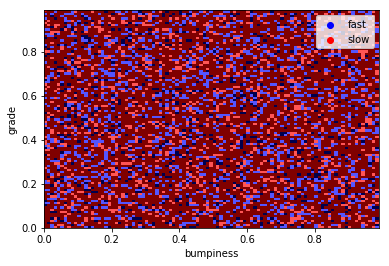

In [67]:
pretty_picture(dummy, X_test.as_matrix(), y_test.as_matrix())

## Treating It As A Classification Task

### Attempt LinearSVC Model

In [68]:
from sklearn.svm import SVC
svc = SVC().fit(X_train, y_train) 

In [69]:
svc.score(X_test, y_test)

0.6207989854153456

In [70]:
pretty_picture(svc, X_test.as_matrix(), y_test.as_matrix())

ValueError: X.shape[1] = 2 should be equal to 137, the number of features at training time

## Treating It As A Regrssion Task

### Attempt LinearRegression Model

In [ ]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(X_train, y_train) 

In [ ]:
lin.score(X_test, y_test)